# Test Time Augmention

After training an ensemble or any other bayesian neural network on a dataset, we create an augmented version of the dataset to test on. This augmented dataset allows us probe our model's confidence in predictions. In this example we are working with the MNIST dataset, and apply rotations as well as noise at test time. By plotting the change in logits and probabilities over a range of rotations we can obeserve our model's uncertainty when viewing new data that is not similar to the training set.

## Rotation Augmentation

##### Dataset

In [1]:
import torch
import copy
import os
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from experiments.nns.bdl import SelectMNISTDataset


# Define the path to directory containing MNIST
mnist_directory = os.path.abspath(os.path.join(os.path.dirname(os.path.abspath("uncertainty.ipynb")), "..","..","..","..","..","..","..", "/usr/data1/vision/data/"))


# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the MNIST training dataset
train_dataset = SelectMNISTDataset(root=mnist_directory, train=True, numbers = [0,1,2,3,4,5,6,7,8,9], num_entries_per_digit=10, transform=transform)

## Creating rotated dataset

In [2]:
import torch
import copy
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from experiments.nns.bdl import CustomMNISTDataset

# Choose what number we would like to test
selected_numbers = [1]

rotation_angles = []
for i in range(12):
    rotation_angles.append(i*5.5)
def get_rotated_mnist_dataset(degrees):
    rotate_transform = transforms.Compose([
            transforms.RandomRotation(degrees=(degrees, degrees), fill=(0,)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
    rotated_dataset = CustomMNISTDataset(root=mnist_directory, numbers=selected_numbers, train=False, transform=rotate_transform)
    rotated_loader = DataLoader(rotated_dataset, batch_size=512, shuffle=False)
    return rotated_dataset, rotated_loader
rotated_datasets = []
rotated_loaders = []

for angle in rotation_angles:
    rotated_dataset, rotated_loader = get_rotated_mnist_dataset(angle)
    rotated_datasets.append(rotated_dataset)
    rotated_loaders.append(rotated_loader)


test_dataset = CustomMNISTDataset(root=mnist_directory, numbers=selected_numbers, train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

## Training

In [3]:
import torch
from torch.utils.data import DataLoader
import push.bayes.ensemble
from experiments.nns.lenet.lenet import LeNet


# Create data loaders
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
epochs = 50
n = 25
lr = 0.01

ensemble = push.bayes.ensemble.train_deep_ensemble(
        train_loader,
        torch.nn.CrossEntropyLoss(),
        epochs,
        LeNet,
        num_devices=2,
        num_ensembles=n,
        cache_size=25
    )

100%|██████████| 50/50 [00:19<00:00,  2.62it/s, loss=tensor(0.1532)]


In [4]:
import push.bayes.swag

pretrain_epochs = 25
swag_epochs = 25
swag = push.bayes.swag.train_mswag(
    train_loader,
    torch.nn.CrossEntropyLoss(),
    pretrain_epochs,
    swag_epochs,
    LeNet,
    num_devices = 2,
    num_models = n,
    lr = lr,
)

100%|██████████| 25/25 [00:31<00:00,  1.27s/it, loss=tensor(0.4719)]


In [5]:
import push.bayes.stein_vgd

svgd = push.bayes.stein_vgd.train_svgd(
    train_loader,                       # Dataloader
    torch.nn.CrossEntropyLoss(),        # Loss Fn
    epochs,                             # Epochs
    10,                                  # Number of particles
    LeNet,                              # NN
    lengthscale = 0.25,                  # Lengthscale
    lr = 3e-1,                          # Learning Rate
    num_devices = 2,                    # Number of devices
)

  0%|          | 0/50 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 26.00 MiB. GPU 0 has a total capacity of 23.69 GiB of which 22.88 MiB is free. Process 1419263 has 16.27 GiB memory in use. Including non-PyTorch memory, this process has 7.39 GiB memory in use. Of the allocated memory 5.98 GiB is allocated by PyTorch, and 1.08 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Inference

In [ ]:
ensemble_outputs = []
for loader in rotated_loaders:
    ensemble_outputs.append(ensemble.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))

swag_outputs = []
for loader in rotated_loaders:
    swag_outputs.append(swag.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))

svgd_outputs = []
for loader in rotated_loaders:
    svgd_outputs.append(svgd.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))

def get_mode(output, mode):
    return output[mode]

## Helper functions for output and plots

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


def get_imgs(loaders, idx_image_to_display = 0):
    imgs = []
    for loader in loaders:
        # loader = DataLoader(dataset, batch_size=512, shuffle=False)
        for images, labels in loader:
            imgs.append(images[idx_image_to_display])
            break
    return imgs




def offset_image(coord, i, ax, low_img, low_index, zoom, imgs):
    '''mnist_classification_mc_dropout.ipynb [1]'''
    img = imgs[i]
    im = OffsetImage(img.squeeze(), zoom=zoom)
    im.image.axes = ax

    ab = AnnotationBbox(
        im,
        (coord, low_img),
        xybox=(0.0, low_index),
        frameon=False,
        boxcoords="offset points",
    )
    ax.add_artist(ab)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_logits(outputs, title, loaders, idx_image_to_display=0):
    fig, ax = plt.subplots(1)
    zoom = 0.4
    index = np.arange(len(outputs))
    for i, output in enumerate(outputs):
        ax.eventplot(
            get_mode(output, "logits")[:,:,(1,3,7)][idx_image_to_display][:,(0)],
            orientation="vertical",
            lineoffsets=i,
            linelengths=0.8,
            colors="green",
            alpha=0.75,
        )
        ax.eventplot(
            get_mode(output, "logits")[:,:,(1,3,7)][idx_image_to_display][:,(1)],
            orientation="vertical",
            lineoffsets=i,
            linelengths=0.8,
            colors="orange",
            alpha=0.75,
        )
        ax.eventplot(
            get_mode(output, "logits")[:,:,(1,3,7)][idx_image_to_display][:,(2)],
            orientation="vertical",
            lineoffsets=i,
            linelengths=0.8,
            colors="blue",
            alpha=0.6,
        )

    ax.set_xticks(index)
    ax.set_xticklabels(index + 1)
    ax.tick_params(axis="x", which="major", pad=8)
    ax.set_ylabel("Logits")
    l, h = ax.get_ylim()
    imgs = get_imgs(loaders, idx_image_to_display)
    for i in index:
        offset_image(i, i, ax, l, l - 5, zoom, imgs)
    ax.legend(["1", "5", "7"], bbox_to_anchor=(0.6, 1.0))
    fig.suptitle(title, fontsize=16, y=1.05)
    plt.show()

def plot_probability(outputs, title, loaders, idx_image_to_display=0):
    fig, ax = plt.subplots(1)
    zoom = 0.4
    index = np.arange(len(outputs))
    for i, output in enumerate(outputs):
        '''mnist_classification_mc_dropout.ipynb [1]'''
        ax.eventplot(
            get_mode(output, "prob")[:,:,(1,3,7)][idx_image_to_display][:,(0)],
            orientation="vertical",
            lineoffsets=i,
            linelengths=0.8,
            colors="green",
            alpha=0.75,
        )
        ax.eventplot(
            get_mode(output, "prob")[:,:,(1,3,7)][idx_image_to_display][:,(1)],
            orientation="vertical",
            lineoffsets=i,
            linelengths=0.8,
            colors="orange",
            alpha=0.75,
        )
        ax.eventplot(
            get_mode(output, "prob")[:,:,(1,3,7)][idx_image_to_display][:,(2)],
            orientation="vertical",
            lineoffsets=i,
            linelengths=0.8,
            colors="blue",
            alpha=0.6,
        )

    ax.set_xticks(index)
    ax.set_xticklabels(index + 1)
    ax.tick_params(axis="x", which="major", pad=8)
    ax.set_ylabel("Probabilities")
    l, h = ax.get_ylim()
    imgs = get_imgs(loaders, idx_image_to_display)
    for i in index:
        offset_image(i, i, ax, l, l - 5, zoom, imgs)
    ax.legend(["1", "5", "7"], bbox_to_anchor=(0.6, 1.0))
    fig.suptitle(title, fontsize=16, y=1.05)
    # sns.despine()
    # savefig("mnist_softmax_input", tight_bbox=True, pad=1)
    plt.show()

In [ ]:
plot_logits(ensemble_outputs, "Ensemble Logits", rotated_loaders)
plot_logits(swag_outputs, "SWAG Logits", rotated_loaders)
plot_logits(svgd_outputs, "SVGD Logits", rotated_loaders)

plot_probability(ensemble_outputs, "Ensemble Probability", rotated_loaders)
plot_probability(swag_outputs, "SWAG Probability", rotated_loaders)
plot_probability(svgd_outputs, "SVGD Probability", rotated_loaders)

NameError: name 'plot_logits' is not defined

# Gaussian Noise

In [ ]:
import torch
import copy
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from experiments.nns.bdl import CustomMNISTDataset
from experiments.nns.bdl import AddGaussianNoise
from experiments.nns.bdl import AddImpulseNoise
from experiments.nns.bdl import AddDefocusBlur


# Choose what number we would like to test
selected_numbers = [1]
variances = [0.1,0.2,0.4,0.8,1.0,1.2,1.4,1.6,1.8]
probs = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
scales = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
radi = [1, 2, 3, 4, 5, 6, 7, 8, 9]

def get_noisy_mnist_dataset(selected_numbers, noise):
    noisy_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    noise
    ])
    noisy_dataset = SelectMNISTDataset(root=mnist_directory, numbers=selected_numbers, num_entries_per_digit=1, train=False, transform=noisy_transform)
    noisy_loader = DataLoader(noisy_dataset, batch_size=1, shuffle=False)
    return noisy_dataset, noisy_loader

gaussian_datasets = []
gaussian_loaders = []
for variance in variances:
    gaussian_dataset, gaussian_loader = get_noisy_mnist_dataset(selected_numbers, AddGaussianNoise(0., variance))
    gaussian_datasets.append(gaussian_dataset)
    gaussian_loaders.append(gaussian_loader)

impulse_datasets = []
impulse_loaders = []
for prob in probs:
    impulse_dataset, impulse_loader = get_noisy_mnist_dataset(selected_numbers, AddImpulseNoise(prob))
    impulse_datasets.append(impulse_dataset)
    impulse_loaders.append(impulse_loader)

defocus_datasets = []
defocus_loaders = []
for radius in radi:
    defocus_dataset, defocus_loader = get_noisy_mnist_dataset(selected_numbers, AddDefocusBlur(radius))
    defocus_datasets.append(defocus_dataset)
    defocus_loaders.append(defocus_loader)

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

gaussian_ensemble_outputs = []
gaussian_swag_outputs = []
gaussian_svgd_outputs = []
for loader in gaussian_loaders:
    gaussian_ensemble_outputs.append(ensemble.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))
    gaussian_swag_outputs.append(swag.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))
    gaussian_svgd_outputs.append(svgd.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))

impulse_ensemble_outputs = []
impulse_swag_outputs = []
impulse_svgd_outputs = []
for loader in impulse_loaders:
    impulse_ensemble_outputs.append(ensemble.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))
    impulse_swag_outputs.append(swag.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))
    impulse_svgd_outputs.append(svgd.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))

defocus_ensemble_outputs = []
defocus_swag_outputs = []
defocus_svgd_outputs = []
for loader in defocus_loaders:
    defocus_ensemble_outputs.append(ensemble.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))
    defocus_swag_outputs.append(swag.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))
    defocus_svgd_outputs.append(svgd.posterior_pred(loader, f_reg=False, mode=["mode","logits","prob"]))


def get_mode(output, mode):
    return output[mode]



In [ ]:
# num_images_to_display = 
idx_image_to_display = 0
imgs = []
lbls = []
for dataset in gaussian_datasets:
    gaussian_loader_small = DataLoader(dataset, batch_size=512, shuffle=False)
    for images, labels in gaussian_loader_small:
        imgs.append(images[idx_image_to_display])
        lbls.append(labels[idx_image_to_display])
        break

def offset_image(coord, i, ax, low_img, low_index, zoom):
    '''mnist_classification_mc_dropout.ipynb [1]'''
    img = imgs[i]
    im = OffsetImage(img.squeeze(), zoom=zoom)
    im.image.axes = ax

    ab = AnnotationBbox(
        im,
        (coord, low_img),
        xybox=(0.0, low_index),
        frameon=False,
        boxcoords="offset points",
    )
    ax.add_artist(ab)

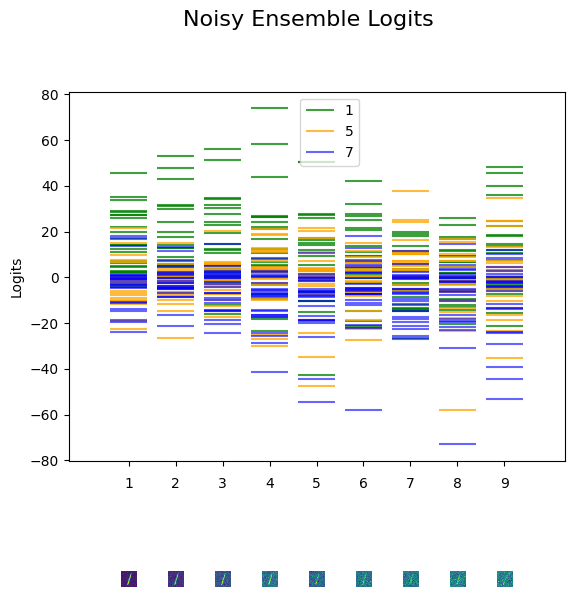

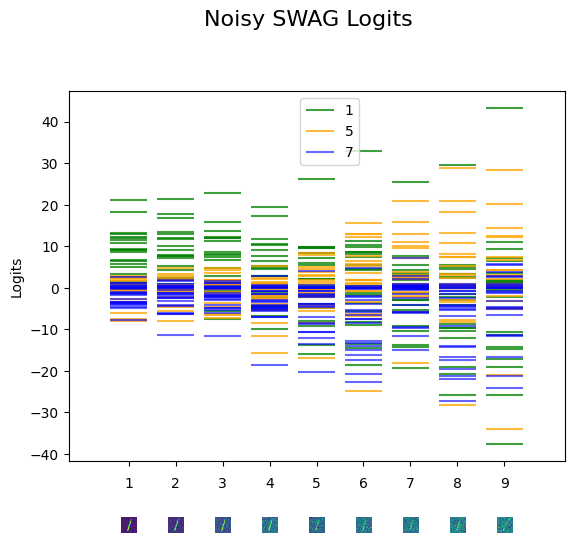

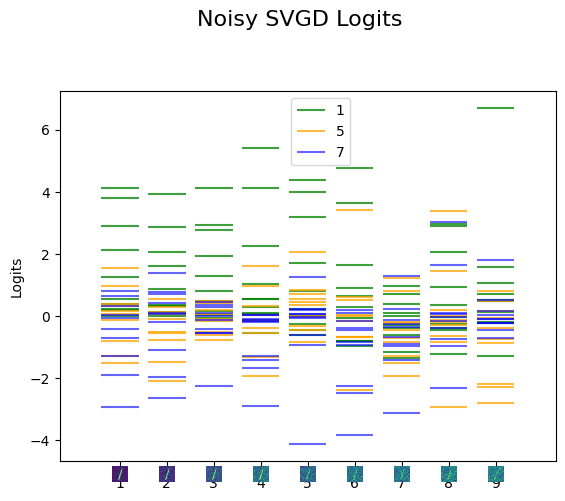

In [ ]:
plot_logits(gaussian_ensemble_outputs, "Noisy Ensemble Logits", idx_image_to_display)
plot_logits(gaussian_swag_outputs, "Noisy SWAG Logits", idx_image_to_display)
plot_logits(gaussian_svgd_outputs, "Noisy SVGD Logits", idx_image_to_display)

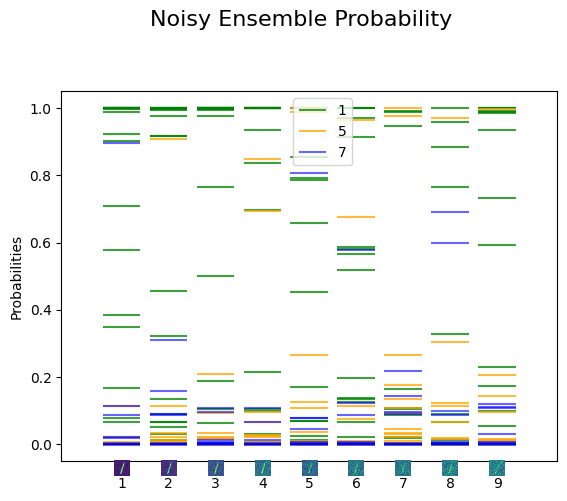

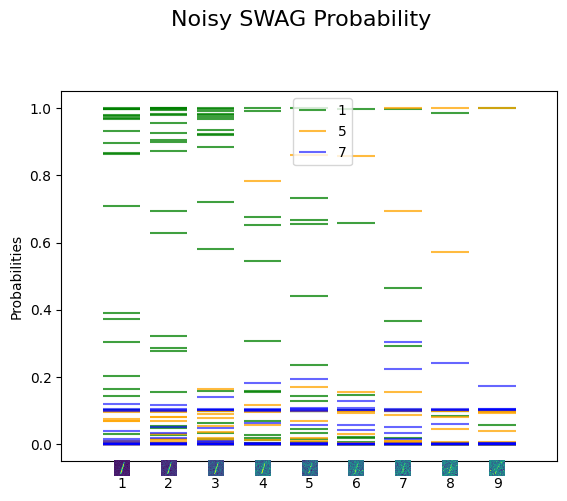

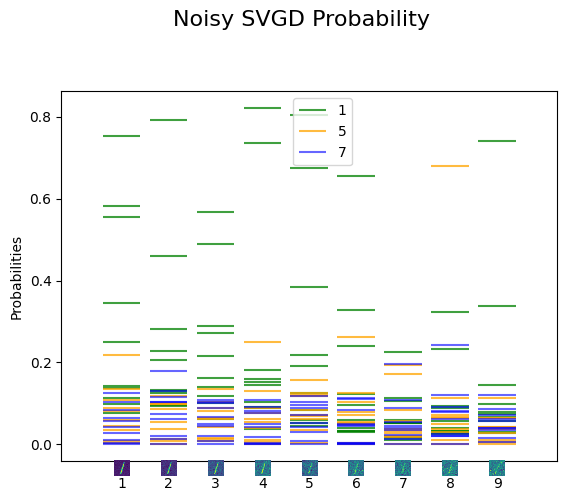

In [ ]:
plot_probability(gaussian_ensemble_outputs, "Noisy Ensemble Probability", idx_image_to_display)
plot_probability(gaussian_swag_outputs, "Noisy SWAG Probability", idx_image_to_display)
plot_probability(gaussian_svgd_outputs, "Noisy SVGD Probability", idx_image_to_display)

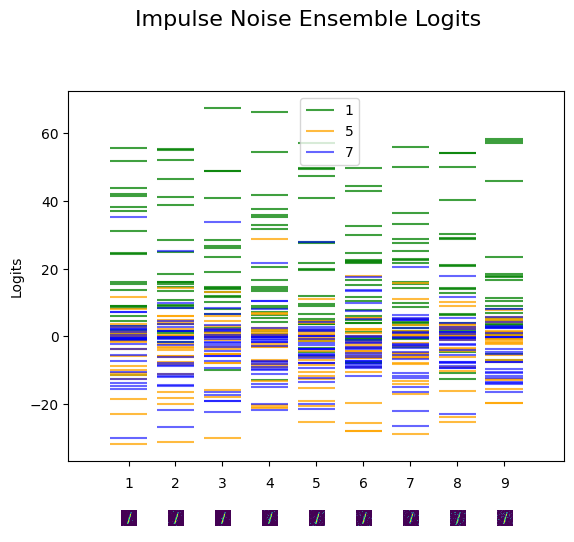

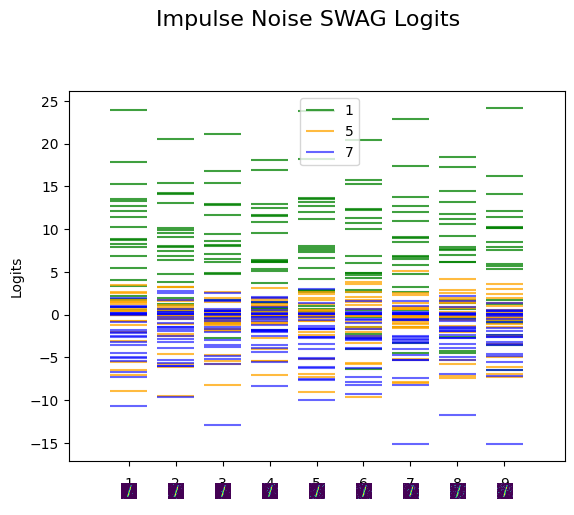

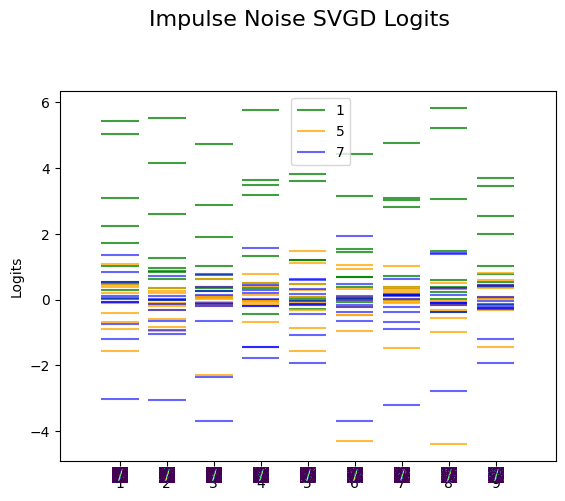

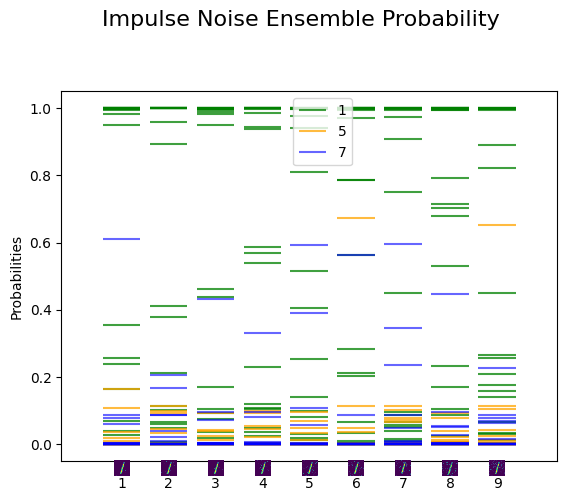

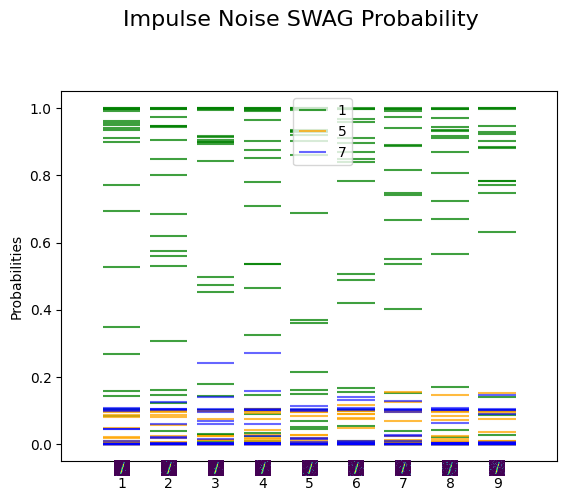

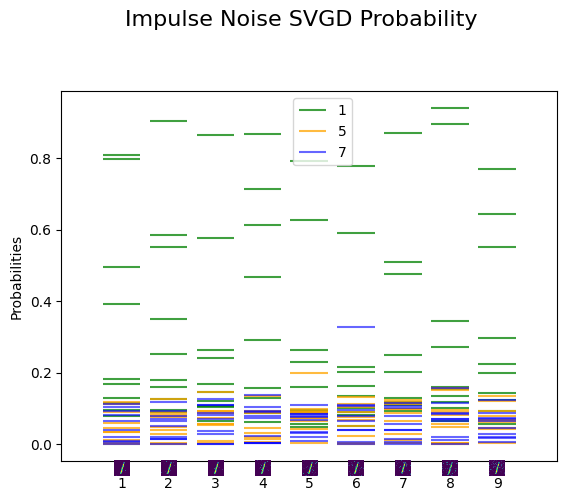

In [ ]:
# num_images_to_display = 
idx_image_to_display = 0
imgs = []
lbls = []
for dataset in impulse_datasets:
    impulse_loader_small = DataLoader(dataset, batch_size=512, shuffle=False)
    for images, labels in impulse_loader_small:
        imgs.append(images[idx_image_to_display])
        lbls.append(labels[idx_image_to_display])
        break

plot_logits(impulse_ensemble_outputs, "Impulse Noise Ensemble Logits", idx_image_to_display)
plot_logits(impulse_swag_outputs, "Impulse Noise SWAG Logits", idx_image_to_display)
plot_logits(impulse_svgd_outputs, "Impulse Noise SVGD Logits", idx_image_to_display)

plot_probability(impulse_ensemble_outputs, "Impulse Noise Ensemble Probability", idx_image_to_display)
plot_probability(impulse_swag_outputs, "Impulse Noise SWAG Probability", idx_image_to_display)
plot_probability(impulse_svgd_outputs, "Impulse Noise SVGD Probability", idx_image_to_display)

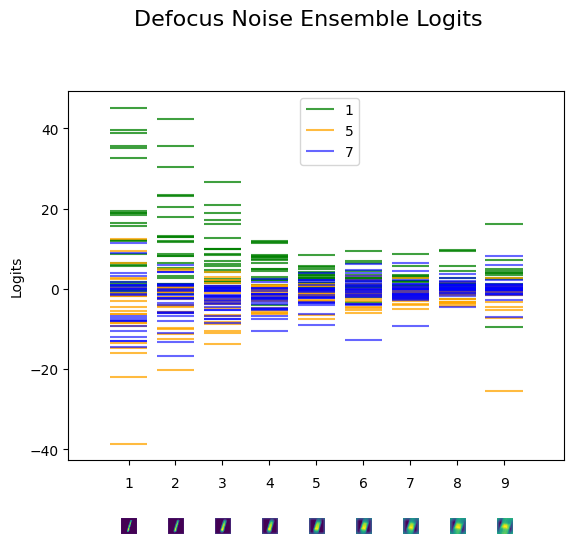

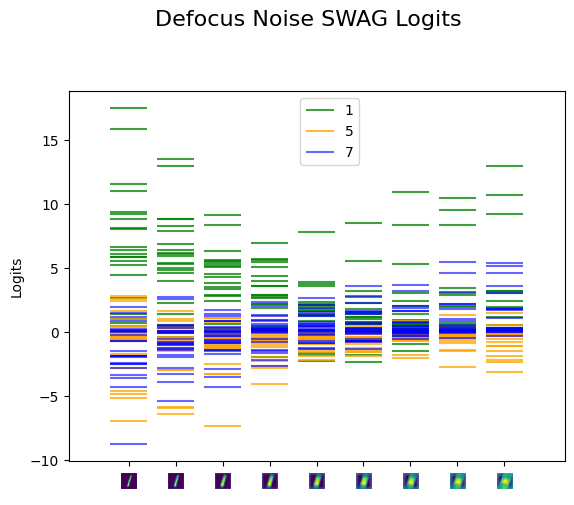

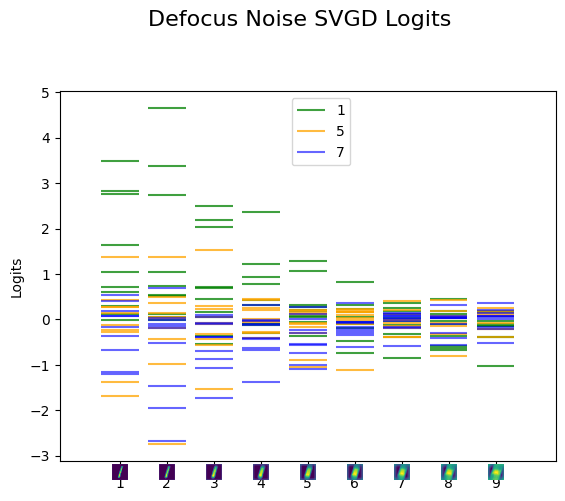

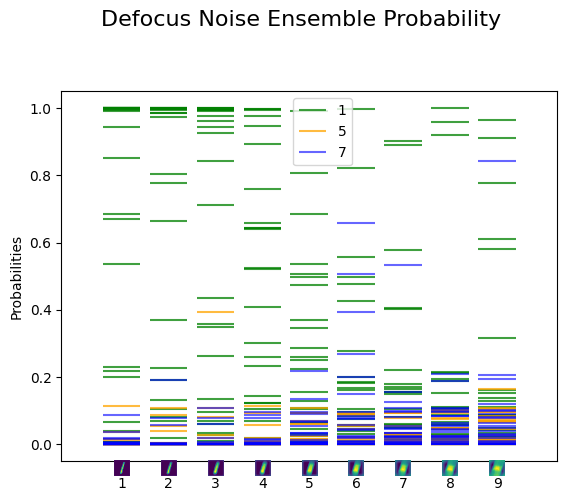

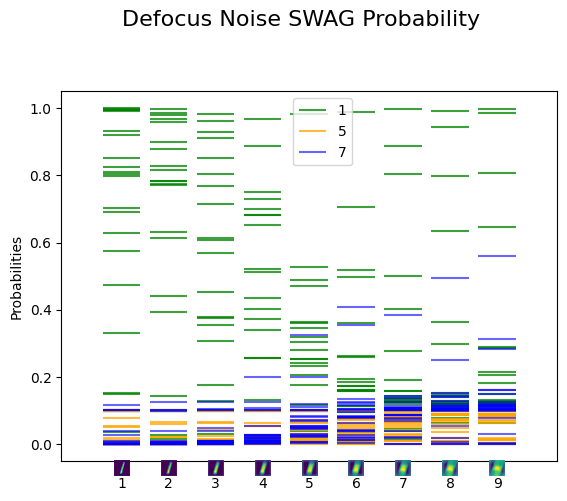

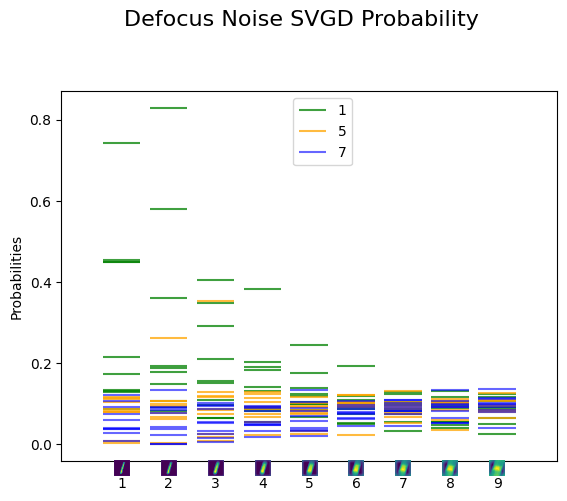

In [ ]:
# num_images_to_display = 
idx_image_to_display = 0
imgs = []
lbls = []
for dataset in defocus_datasets:
    defocus_loader_small = DataLoader(dataset, batch_size=512, shuffle=False)
    for images, labels in defocus_loader_small:
        imgs.append(images[idx_image_to_display])
        lbls.append(labels[idx_image_to_display])
        break

plot_logits(defocus_ensemble_outputs, "Defocus Noise Ensemble Logits", idx_image_to_display)
plot_logits(defocus_swag_outputs, "Defocus Noise SWAG Logits", idx_image_to_display)
plot_logits(defocus_svgd_outputs, "Defocus Noise SVGD Logits", idx_image_to_display)

plot_probability(defocus_ensemble_outputs, "Defocus Noise Ensemble Probability", idx_image_to_display)
plot_probability(defocus_swag_outputs, "Defocus Noise SWAG Probability", idx_image_to_display)
plot_probability(defocus_svgd_outputs, "Defocus Noise SVGD Probability", idx_image_to_display)

[1] Kevin Murphy. Probabilistic Machine Learning Advanced Topics. Chapter 17. The MIT Press: Adaptive computation and machine learning series (2023). Cambridge, Massachusetts.